# The Problem
### Distributed Denial of Service (DDoS) attack vectors are one of the most powerful methods of corrupting various computer systems and applications. They can exhaust the computational resoures which can lead to service's disruption or huge financial losses by utilizing too much energy or purchased resources on some cloud platform

### For businesses that rely on cloud technologies it is crucial to have availability of their services since it can be one of the value propositions that this business has. Therefore, I would like to create a machile learning pipeline that can be used in company's Intrusion Detection System (IDS) to indicate DDoS attacks and help to mitigate them

# Machine Learning Task
### Develop a machine learning model to classify incoming network packets and identify if packets are malicious or normal

# Dataset overview
### To train the model, the CIC-IDS2017 dataset was used. The dataset of Canadian Institute of Cybersecurity contains modern attacks stored in a real-world format (PCAP). The collection of captured packets 

## $$\{(x_i,y_i)\}^N_{i=1}$$
### - $N(size\;of\;the\;collection) = 225745$ corresponds to the number of rows in the dataset
### - $x_i$ is D-dimensional feature vector (columns), where $D=78\;$(excluding the target label)
### - $y_i$ is a target label for every $x_i$

#

# Learning Algorithm Selection
### - Explainability: the model will be presented to technical audience and doesn't necessairly require explainability
### - In-memory vs out-of-memory: in the scope of this assignment, the entire dataset can be loaded into computer's RAM. Hovewer, it will be assumed that the model has to be updated incrementally to simulate the real-world scenario of using intrusion detection systems
### - The number of features and examples is more than 100k
### - The feature vector $x_i$ is mostly numerical
### - Is the data linear???
### - The training speed of the model is not a constraint
### - Prediction speed should be relatively fast

# Possible classification ML models:
- Support Vector Machine (SVM)
- KNeighbours Classifier
- Logistic Regression

# The machine learning pipeline

### Dependencies

In [1]:
# dataframes and plotting
import pandas as pd
import matplotlib.pyplot as plt

# math
import numpy as np

#feature engineering
from sklearn.preprocessing import MinMaxScaler

# creating sets
from sklearn.model_selection import train_test_split

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# evaluation metrics
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

# etc
from IPython.display import Image

# Data Exploration

### Data Overview

In [2]:
ddos = pd.read_csv("./DDoS_dataset.csv")

In [3]:
ddos.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Feature Selection

If the dataset is big (this is the case of this ML pipeline), it is better to select features prior to any computations. It will save computational power in the future. The output of previous ddos.info() function revealed that the dataset uses 136.1+ MB of memory. After feature selection, this number will drop to 15.5 MB.  
  
In this section, the features that will be used for the ML algorithms will be defined and selected. The authors of this research paper (Chanu, U.S., Singh, K.J. and Chanu, Y.J. eds., 2023) had the same task and dataset that I have. Each feature was paired and tested with Pearson Correlation Cefficient (they also used other correlation coefficients, but the feature selection remained the same). Nine features with the greatest Pearson coefficient were selected:

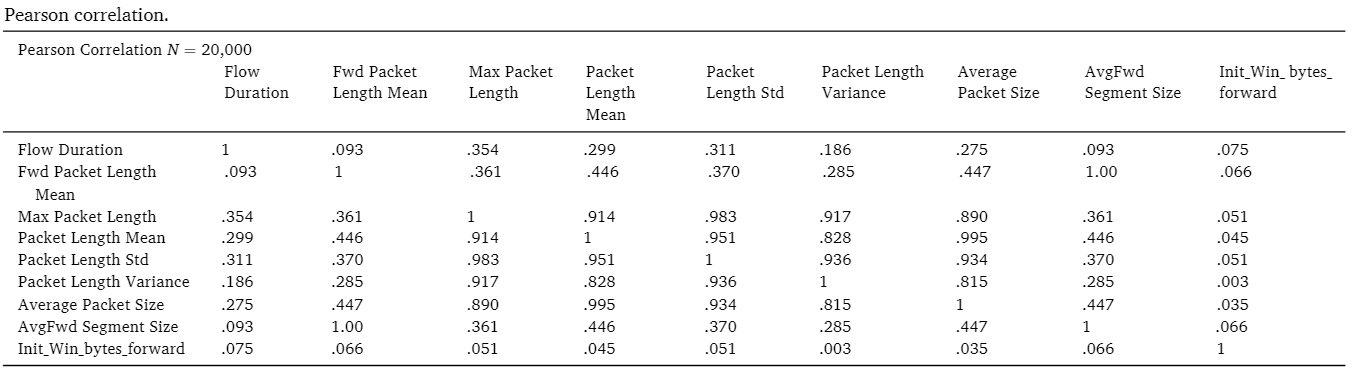

In [4]:
Image("./features_pearson_correlation.png")

In [5]:
# remove unnecessary spaces from dataset's column names
ddos_mapper = lambda x : x.strip()
ddos = ddos.rename(mapper=ddos_mapper, axis=1)

selected_features = ["Flow Duration",
                     "Fwd Packet Length Mean",
                     "Max Packet Length",
                     "Packet Length Mean",
                     "Packet Length Std",
                     "Packet Length Variance",
                     "Average Packet Size", 
                     "Avg Fwd Segment Size",
                     "Init_Win_bytes_forward",
                     "Label"
                    ]

ddos = ddos[selected_features]
ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Flow Duration           225745 non-null  int64  
 1   Fwd Packet Length Mean  225745 non-null  float64
 2   Max Packet Length       225745 non-null  int64  
 3   Packet Length Mean      225745 non-null  float64
 4   Packet Length Std       225745 non-null  float64
 5   Packet Length Variance  225745 non-null  float64
 6   Average Packet Size     225745 non-null  float64
 7   Avg Fwd Segment Size    225745 non-null  float64
 8   Init_Win_bytes_forward  225745 non-null  int64  
 9   Label                   225745 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 17.2+ MB


# Data Preprocessing

### Data Cleaning

This step tests if there are NA or Inf values in the dataset

In [6]:
print("NA Test", "\n", "\n", ddos.isna().any(), "\n")
print("Infinity Values Test", "\n", "\n", ddos.drop(columns="Label").map(np.isinf).any())

NA Test 
 
 Flow Duration             False
Fwd Packet Length Mean    False
Max Packet Length         False
Packet Length Mean        False
Packet Length Std         False
Packet Length Variance    False
Average Packet Size       False
Avg Fwd Segment Size      False
Init_Win_bytes_forward    False
Label                     False
dtype: bool 

Infinity Values Test 
 
 Flow Duration             False
Fwd Packet Length Mean    False
Max Packet Length         False
Packet Length Mean        False
Packet Length Std         False
Packet Length Variance    False
Average Packet Size       False
Avg Fwd Segment Size      False
Init_Win_bytes_forward    False
dtype: bool


### Creating training, validation, and testing sets

In [7]:
ddos_main, _ = train_test_split(ddos, train_size=0.2)
ddos_training, ddos_other = train_test_split(ddos_main, train_size=0.5)
ddos_validation, ddos_test = train_test_split(ddos_other, test_size=0.5)

# Feature Engineering

SVM, KNearest Neighbours, and Logistic regression don't strictly require standartization or normalization. However, all algorithms will perform better because of their features:
- Logistic Regression uses Gradient Descent as its optimization algorithm. If during partial derivative usage with respect to features $w_1, w_2, w_D$ one of them had [0, 1000] range and others [0, 0.001], then the derivative with the respect to higher value will dominate.
- KNearest Neighbours uses Euclidean or cosine distance to determine the similarity of vector directions (Andriy Burkow, 2019). If one feature will have significantly larger scale, this feature will dominate the distance calulation.
- SVM measures the Euclidean norm between support vectors to set the hyperplane equally distant from the nearest data points of each class (Andriy Burkow, 2019). If one feature will dominate others, SVM can place the hyperplane in the favor of this feature, making others insignificant.

These are the reasons why model performances will be evaluated with feature scaling. First, the distributions of features will be displayed to visually understand the range of values. Then, the data will be normalized using MinMaxScaler from scikit-learn.

array([[<Axes: title={'center': 'Flow Duration'}>,
        <Axes: title={'center': 'Fwd Packet Length Mean'}>,
        <Axes: title={'center': 'Max Packet Length'}>],
       [<Axes: title={'center': 'Packet Length Mean'}>,
        <Axes: title={'center': 'Packet Length Std'}>,
        <Axes: title={'center': 'Packet Length Variance'}>],
       [<Axes: title={'center': 'Average Packet Size'}>,
        <Axes: title={'center': 'Avg Fwd Segment Size'}>,
        <Axes: title={'center': 'Init_Win_bytes_forward'}>]], dtype=object)

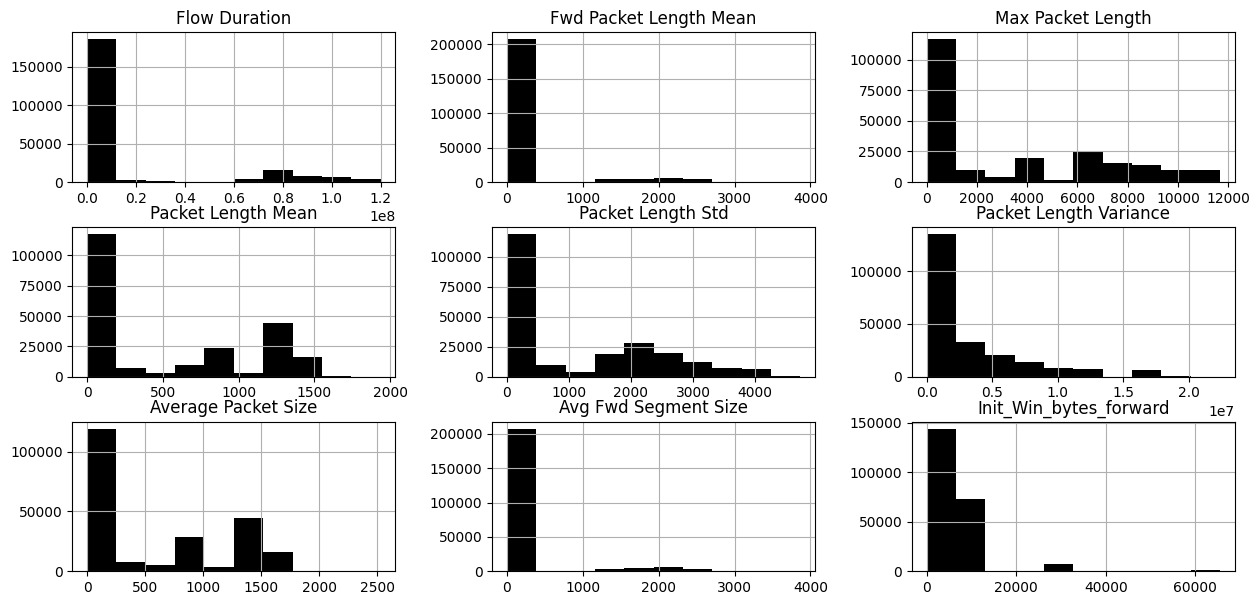

In [8]:
numerical_features = ["Flow Duration",
                     "Fwd Packet Length Mean",
                     "Max Packet Length",
                     "Packet Length Mean",
                     "Packet Length Std",
                     "Packet Length Variance",
                     "Average Packet Size", 
                     "Avg Fwd Segment Size",
                     "Init_Win_bytes_forward"
                    ]
ddos[numerical_features].hist(figsize=(15, 7), color="black")

In [9]:
scaler = MinMaxScaler()

array([[<Axes: title={'center': 'Flow Duration'}>,
        <Axes: title={'center': 'Fwd Packet Length Mean'}>,
        <Axes: title={'center': 'Max Packet Length'}>],
       [<Axes: title={'center': 'Packet Length Mean'}>,
        <Axes: title={'center': 'Packet Length Std'}>,
        <Axes: title={'center': 'Packet Length Variance'}>],
       [<Axes: title={'center': 'Average Packet Size'}>,
        <Axes: title={'center': 'Avg Fwd Segment Size'}>,
        <Axes: title={'center': 'Init_Win_bytes_forward'}>]], dtype=object)

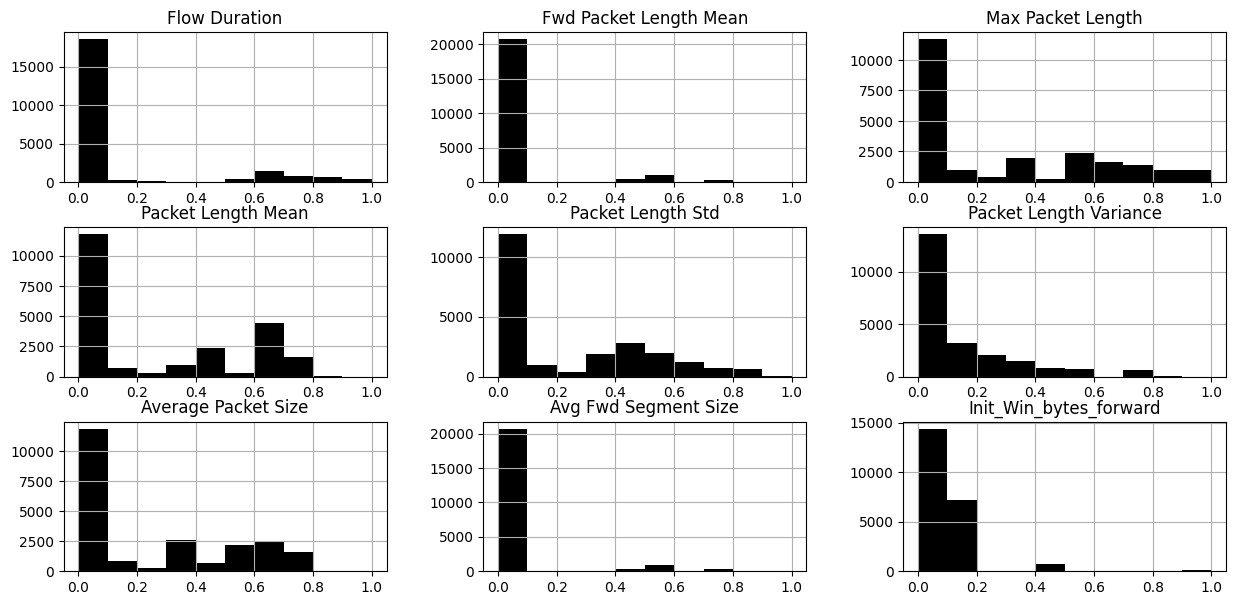

In [10]:
ddos_training[numerical_features] = scaler.fit_transform(ddos_training[numerical_features])
ddos_training[numerical_features].hist(figsize=(15, 7), color="black")

In [11]:
ddos_validation[numerical_features] = scaler.fit_transform(ddos_validation[numerical_features])
ddos_validation.head()

,Flow Duration,Fwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Init_Win_bytes_forward,Label
181931,0.061866,0.002068,0.000517,0.003612,0.000000,0.000000e+00,0.003627,0.002068,0.003922,DDoS
207442,0.000195,0.001034,0.000517,0.001204,0.000791,6.250000e-07,0.001451,0.001034,0.001099,BENIGN
120449,0.722974,0.667011,0.622251,0.439532,0.466780,2.177554e-01,0.376564,0.667011,0.003510,BENIGN
79225,0.067557,0.002068,0.000517,0.003612,0.000000,0.000000e+00,0.003385,0.002068,0.003510,BENIGN
30491,0.004317,0.002987,0.755498,0.875000,0.710869,5.050365e-01,0.803191,0.002987,0.125015,DDoS


In [12]:
ddos_test[numerical_features] = scaler.fit_transform(ddos_test[numerical_features])
ddos_test.head()

,Flow Duration,Fwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Init_Win_bytes_forward,Label
30740,0.004869,0.002241,0.377749,0.700000,0.375584,0.14098,0.624704,0.002241,0.125015,DDoS
208128,0.000099,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,BENIGN
89866,0.013266,0.002241,1.000000,0.875452,0.935407,0.87500,0.803606,0.002241,0.125015,DDoS
36227,0.099834,0.001552,0.000517,0.003612,0.000000,0.00000,0.003482,0.001552,0.003922,DDoS
23800,0.056596,0.001552,0.000517,0.003612,0.000000,0.00000,0.003627,0.001552,0.003922,DDoS


In [13]:
# training x and y vectors
ddos_training_X = ddos_training.drop(columns="Label")
ddos_training_Y = ddos_training["Label"]

# validation x and y vectors
ddos_validation_X = ddos_validation.drop(columns="Label")
ddos_validation_Y = ddos_validation["Label"]

# test x and y vectors
ddos_test_X = ddos_test.drop(columns="Label")
ddos_test_Y = ddos_test["Label"]

In [14]:
def display_label_counts(dt, label):
    label_counts = dt[label].value_counts()
    plt.bar(label_counts.index, label_counts.values, color="black")

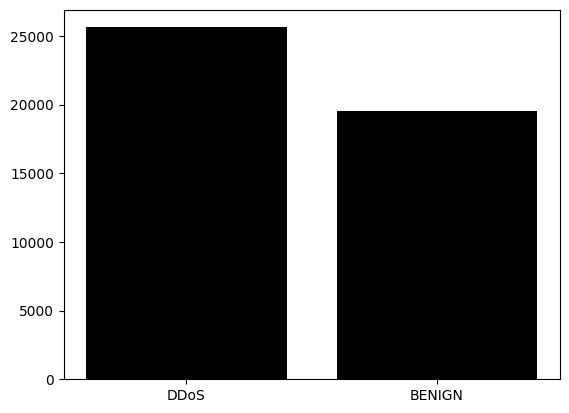

In [15]:
display_label_counts(ddos_main, "Label")

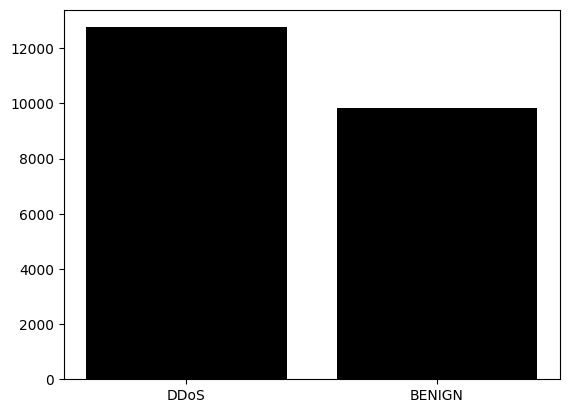

In [16]:
display_label_counts(ddos_training, "Label")

# Model Training and Hyperperemeter Tuning: Training Set

### SVM

Since hyperparameter tuning is too heavy to compute on the whole training set, I will take a sample from the set and use it.

In [17]:
training_sample_X, _, training_sample_Y, _ = train_test_split(ddos_training_X, ddos_training_Y, test_size=0.9)
training_sample_X

,Flow Duration,Fwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Init_Win_bytes_forward
190457,0.018458,0.001850,0.000517,0.003098,0.000000,0.000000,0.003098,0.001850,0.003922
22729,0.004782,0.002672,0.503665,0.600620,0.451933,0.204127,0.556129,0.002672,0.125015
39563,0.012845,0.002672,0.503665,0.600310,0.404013,0.163134,0.555842,0.002672,0.125015
211641,0.043190,0.014334,0.156533,0.197856,0.138980,0.019305,0.177563,0.014334,0.125015
19099,0.007641,0.002672,1.000000,0.750774,0.866008,0.750000,0.715023,0.002672,0.125015
...,...,...,...,...,...,...,...,...,...
28439,0.609820,0.002158,0.503665,0.430342,0.444490,0.197460,0.386204,0.002158,0.003922
184554,0.084579,0.175863,0.195774,0.218054,0.165515,0.027380,0.198230,0.175863,0.125015
127066,0.006893,0.002672,0.377749,0.600620,0.402400,0.161834,0.556129,0.002672,0.125015
180789,0.000287,0.002672,0.503665,0.600310,0.404013,0.163134,0.555842,0.002672,0.125015


In [18]:
SVM_model = SVC()

In [19]:
SVM_grid = {
    # C values were chosen experimentally by iteratively running grid search
    "C": [15, 20, 30],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

SVM_grid_search = GridSearchCV(estimator=SVM_model, param_grid=SVM_grid, scoring="accuracy", n_jobs=-1)
SVM_grid_search.fit(training_sample_X, training_sample_Y)

print("Best Parameters:", SVM_grid_search.best_params_)
print("Best Cross-Validation Score:", SVM_grid_search.best_score_)

Best Parameters: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8998695131762258


C:\Users\seelennebel\dev\AI_ML_Assignment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [20]:
SVM_model = SVC(C=20, kernel="rbf", gamma="scale")
SVM_model.fit(ddos_training_X, ddos_training_Y)

SVC(C=20)

In [21]:
SVM_Y_predict = SVM_model.predict(ddos_test_X)

In [22]:
SVM_precision = precision_score(ddos_test_Y, SVM_Y_predict, pos_label="DDoS")
SVM_precision

np.float64(0.9091047735244776)

### KNN

In [23]:
KNN_model = KNeighborsClassifier()

In [31]:
KNN_grid = {
    # C values were chosen experimentally by iteratively running grid search
    "n_neighbors": [5, 10, 15],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [15, 30, 45]
}

KNN_grid_search = GridSearchCV(estimator=KNN_model, param_grid=KNN_grid, scoring="accuracy", n_jobs=-1)
KNN_grid_search.fit(training_sample_X, training_sample_Y)

print("Best Parameters:", KNN_grid_search.best_params_)
print("Best Cross-Validation Score:", KNN_grid_search.best_score_)

Best Parameters: {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-Validation Score: 0.9601249926417204


In [32]:
KNN_model = KNeighborsClassifier(n_neighbors=5, weights="distance", algorithm="auto", leaf_size=15)

In [33]:
KNN_model.fit(ddos_training_X, ddos_training_Y)

KNeighborsClassifier(leaf_size=15, weights='distance')

In [34]:
KNN_Y_predict = KNN_model.predict(ddos_test_X)

In [35]:
KNN_precision = precision_score(ddos_test_Y, KNN_Y_predict, pos_label="DDoS")
KNN_precision

np.float64(0.9863721804511278)

# References

Andriy Burkow (2019). The Hundred-Page Machine Learning Book

Chanu, U.S., Singh, K.J. and Chanu, Y.J. eds., (2023). A dynamic feature selection technique to detect DDoS attack. [online] ScienceDirect.  
Available at: https://www.sciencedirect.com/science/article/abs/pii/S2214212623000303.